# Using python to mimic FORTRAN CJ code

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing, os, sys, cProfile, pstats, io, traceback, time, random
from scipy.integrate import quad
from scipy.interpolate import interp1d
from scipy.interpolate import griddata
from matplotlib.ticker import LogLocator
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from functools import lru_cache
from joblib import Parallel, delayed
import warnings
from numba import jit, cuda 
warnings.filterwarnings("ignore")

# Reading the input file

In [2]:
filepath = '/Users/AbSir/Desktop/cj22/CJ-code/fitpack/nucl/phi.wbarel_AV18'
gamma_list = []
y_list = []
f2_list = []
f0_list = []
with open(filepath, 'r') as file:
    for line in file:
        try:
            columns = [float(col) for col in line.split()]
            if len(columns) == 8:
                gamma_list.append(columns[0])
                y_list.append(columns[1])
                f2_list.append(columns[6])
                f0_list.append(columns[2])
        except:
            continue
gamma_array = np.array(gamma_list)
y_array = np.array(y_list)
f2_array = np.array(f2_list)
f0_array = np.array(f0_list)

# Performing the interpolation

Text(0.5, 1.0, 'f0 for Various $\\gamma$ Values')

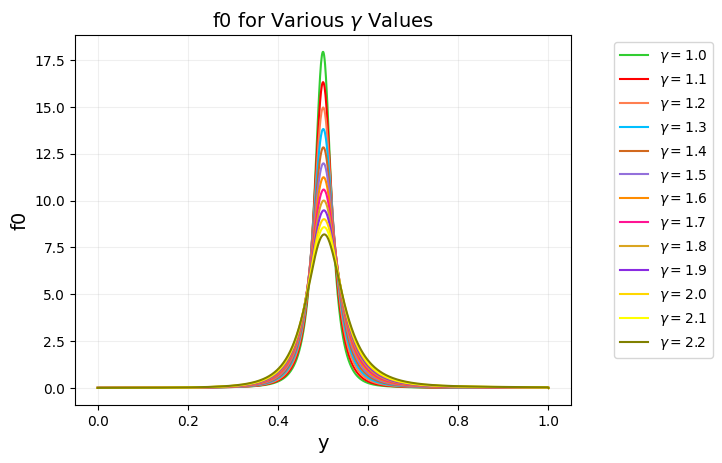

In [3]:
def phi_int2d_fixed_gamma(y_D, gamma_fixed):
    # Find the indices of the gamma values that are equal to the fixed gamma value
    mask = gamma_array == gamma_fixed
    y_filtered = np.array(y_array[mask])
    f2_filtered = np.array(f2_array[mask])
    f0_filtered = np.array(f0_array[mask])
    # y_filtered = 0.5 * y_filtered

    # Perform 1D interpolation along the y axis for the fixed gamma value
    interpolator = interp1d(y_filtered, f0_filtered, kind = 'linear', fill_value = 'extrapolate')

    # Interpolate at the given y value
    result = interpolator(y_D)

    return result

y_D = np.linspace(0, 1, 1000)
f2_1p0 = phi_int2d_fixed_gamma(y_D, 1.0)
f2_1p1 = phi_int2d_fixed_gamma(y_D, 1.1)
f2_1p2 = phi_int2d_fixed_gamma(y_D, 1.2)
f2_1p3 = phi_int2d_fixed_gamma(y_D, 1.3)
f2_1p4 = phi_int2d_fixed_gamma(y_D, 1.4)
f2_1p5 = phi_int2d_fixed_gamma(y_D, 1.5)
f2_1p6 = phi_int2d_fixed_gamma(y_D, 1.6)
f2_1p7 = phi_int2d_fixed_gamma(y_D, 1.7)
f2_1p8 = phi_int2d_fixed_gamma(y_D, 1.8)
f2_1p9 = phi_int2d_fixed_gamma(y_D, 1.9)
f2_2p0 = phi_int2d_fixed_gamma(y_D, 2.0)
f2_2p1 = phi_int2d_fixed_gamma(y_D, 2.1)
f2_2p2 = phi_int2d_fixed_gamma(y_D, 2.2)

col2 = ['forestgreen', 'limegreen', 'red', 'coral', 'deepskyblue', 'chocolate', 'mediumpurple', 'darkorange', 'deeppink', 'goldenrod', 'blueviolet', 'gold', 'mediumspringgreen', 'olive', 'yellow', 'greenyellow', 'springgreen', 'turquoise', 'darkslategray', 'blue', 'darkviolet', 'violet', 'fuchsia', 'maroon', 'pink', 'peru', 'black', 'orchid', 'grey', 'wheat', 'darkkhaki', 'cyan', 'lavender', 'indigo', 'plum', 'sienna', 'tan', 'lavenderblush', 'dimgray']

fig, ax = plt.subplots()
# ax.plot(x, f2, color = 'black', label='f0')
ax.plot(y_D, f2_1p0, color=col2[1], label=r'$\gamma = 1.0$')
ax.plot(y_D, f2_1p1, color=col2[2], label=r'$\gamma = 1.1$')
ax.plot(y_D, f2_1p2, color=col2[3], label=r'$\gamma = 1.2$')
ax.plot(y_D, f2_1p3, color=col2[4], label=r'$\gamma = 1.3$')
ax.plot(y_D, f2_1p4, color=col2[5], label=r'$\gamma = 1.4$')
ax.plot(y_D, f2_1p5, color=col2[6], label=r'$\gamma = 1.5$')
ax.plot(y_D, f2_1p6, color=col2[7], label=r'$\gamma = 1.6$')
ax.plot(y_D, f2_1p7, color=col2[8], label=r'$\gamma = 1.7$')
ax.plot(y_D, f2_1p8, color=col2[9], label=r'$\gamma = 1.8$')
ax.plot(y_D, f2_1p9, color=col2[10], label=r'$\gamma = 1.9$')
ax.plot(y_D, f2_2p0, color=col2[11], label=r'$\gamma = 2.0$')
ax.plot(y_D, f2_2p1, color=col2[14], label=r'$\gamma = 2.1$')
ax.plot(y_D, f2_2p2, color=col2[13], label=r'$\gamma = 2.2$')
ax.grid(alpha = 0.2)
ax.set_xlabel('y', fontsize = 14)
# ax.set_xlim(0.6, 1.4)
ax.set_ylabel('f0', fontsize = 14)
# ax.set_yscale('log')
# ax.set_ylim(1e-4, 3e1)
ax.legend(loc = 'upper right', bbox_to_anchor = (1.3, 1.0))
plt.title(r'f0 for Various $\gamma$ Values', fontsize = 14)
# plt.savefig(f'plots/f2_gamma_{time.time():.0f}.pdf', dpi = 300, bbox_inches = 'tight')

<h1 align="center"><p style="color: yellow"> Avoiding redundant computation </h1></p1>

# Performing the interpolation and integration

In [4]:
def f2_function(x, y_D):
    k = x / y_D
    return 4 * k**0.7 * (1 - k)**3.5 * (1 + 4 * k) + 0.15 * k**(-0.4) * (1 - k)**9 * (1 + 16 * k)

def f2nxn_function(x):
    x_N = 2 * x # Convert from x_D to x_N
    return 4 * x_N**0.7 * (1 - x_N)**3.5 * (1 + 4 * x_N) + 0.15 * x_N**(-0.4) * (1 - x_N)**9 * (1 + 16 * x_N)

# Define the product of f2 and f0 for the integrand
def integrand(y_D, x):
    f0 = phi_int2d_fixed_gamma(y_D, gamma_fixed)
    f2 = f2_function(x, y_D)
    return f2 * f0

results_cache = {}  # Dictionary to cache (avoid multiple computation)

def get_interpolator(gamma_fixed):
    # Check if the interpolator is already computed
    if gamma_fixed not in results_cache:
        # Only want to read the data for the gamma we care about
        mask = gamma_array == gamma_fixed
        y_filtered = y_array[mask]
        f0_filtered = f0_array[mask]
        # Perform 1D interpolation to get the interpolator
        results_cache[gamma_fixed] = interp1d(y_filtered, f0_filtered, kind = 'linear', fill_value = 'extrapolate')
    return results_cache[gamma_fixed]

def phi_int2d_fixed_gamma(y_D, gamma_fixed):
    # Interpolator is an object
    interpolator = get_interpolator(gamma_fixed)
    # The interpolated value at y_D serves as a means to estimate function values at points not explicitly defined in the original dataset
    return interpolator(y_D)

# Perform the integration
def integrate_f2_f0(x):
    f2dxd, error = quad(integrand, x, 1, args = x)
    # f2dxn = f2dxd / 2 # Getting structure function in terms of nucleon momentum fraction
    f2dxn = f2dxd
    return f2dxn

gamma_fixed = 1.0
x = np.linspace(0, 1, 5000) # This is x_D
simple_f2_list = [f2nxn_function(x_val) for x_val in x]
integral_result_list = [integrate_f2_f0(x_val) for x_val in x]
ratio = np.array(integral_result_list) / np.array(simple_f2_list)

# Multiprocessing

In [5]:
def f2_function(x, y_D):
    k = x / y_D
    return 4 * k**0.7 * (1 - k)**3.5 * (1 + 4 * k) + 0.15 * k**(-0.4) * (1 - k)**9 * (1 + 16 * k)

def f2nxn_function(x):
    x_N = 2 * x # Convert from x_D to x_N
    return 4 * x_N**0.7 * (1 - x_N)**3.5 * (1 + 4 * x_N) + 0.15 * x_N**(-0.4) * (1 - x_N)**9 * (1 + 16 * x_N)

# Define the product of f2 and f0 for the integrand
def integrand(y_D, x):
    f0 = phi_int2d_fixed_gamma(y_D, gamma_fixed)
    f2 = f2_function(x, y_D)
    return f2 * f0

def phi_int2d_fixed_gamma(y_D, gamma_fixed):
    # Find the indices of the gamma values that are equal to the fixed gamma value
    mask = gamma_array == gamma_fixed
    y_filtered = np.array(y_array[mask])
    f0_filtered = np.array(f0_array[mask])
    # y_filtered = 0.5 * y_filtered

    # Perform 1D interpolation along the y axis for the fixed gamma value
    interpolator = interp1d(y_filtered, f0_filtered, kind = 'linear', fill_value = 'extrapolate')

    # Interpolate at the given y value
    result = interpolator(y_D)

    return result

# Perform the integration
def integrate_f2_f0(x):
    f2dxd, error = quad(integrand, x, 1, args = x)
    # f2dxn = f2dxd / 2 # Getting structure function in terms of nucleon momentum fraction
    f2dxn = f2dxd
    return f2dxn

warnings.filterwarnings("ignore")
gamma_fixed = 1.0
x = np.linspace(0, 1, 5000) # This is x_D
simple_f2_list = [f2nxn_function(x_val) for x_val in x]
integral_result_list = Parallel(n_jobs=-1)(delayed(integrate_f2_f0)(x_val) for x_val in x)
# integral_result_list, error_list = map(np.array, zip(*results))
# ratio = integral_result_list / np.array(simple_f2_list)
ratio = np.array(integral_result_list) / np.array(simple_f2_list)

/var/folders/_8/jr423pqd4ld_d5cxmtbz54_00000gn/T/ipykernel_24398/543443858.py:3: RuntimeWarning: divide by zero encountered in scalar power
/var/folders/_8/jr423pqd4ld_d5cxmtbz54_00000gn/T/ipykernel_24398/543443858.py:13: RuntimeWarning: invalid value encountered in multiply
/var/folders/_8/jr423pqd4ld_d5cxmtbz54_00000gn/T/ipykernel_24398/543443858.py:32: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
/var/folders/_8/jr423pqd4ld_d5cxmtbz54_00000gn/T/ipykernel_24398/543443858.py:32: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the su

# Passing peak point to quad function

In [6]:
def f2_function(x, y_D):
    k = x / y_D
    return 4 * k**0.7 * (1 - k)**3.5 * (1 + 4 * k) + 0.15 * k**(-0.4) * (1 - k)**9 * (1 + 16 * k)

def f2nxn_function(x):
    x_N = 2 * x # Convert from x_D to x_N
    return 4 * x_N**0.7 * (1 - x_N)**3.5 * (1 + 4 * x_N) + 0.15 * x_N**(-0.4) * (1 - x_N)**9 * (1 + 16 * x_N)

# Define the product of f2 and f0 for the integrand
def integrand(y_D, x):
    f0 = phi_int2d_fixed_gamma(y_D, gamma_fixed)
    f2 = f2_function(x, y_D)
    return f2 * f0

def phi_int2d_fixed_gamma(y_D, gamma_fixed):
    # Find the indices of the gamma values that are equal to the fixed gamma value
    mask = gamma_array == gamma_fixed
    y_filtered = np.array(y_array[mask])
    f0_filtered = np.array(f0_array[mask])
    # y_filtered = 0.5 * y_filtered

    # Perform 1D interpolation along the y axis for the fixed gamma value
    interpolator = interp1d(y_filtered, f0_filtered, kind = 'linear', fill_value = 'extrapolate')

    # Interpolate at the given y value
    result = interpolator(y_D)

    return result

# Perform the integration
def integrate_f2_f0(x):
    f2dxd, error = quad(integrand, x, 1, args = x, points = [0.5])
    # f2dxn = f2dxd / 2 # Getting structure function in terms of nucleon momentum fraction
    f2dxn = f2dxd
    return f2dxn

gamma_fixed = 1.0
x = np.linspace(0, 1, 5000) # This is x_D
simple_f2_list = [f2nxn_function(x_val) for x_val in x]
integral_result_list = [integrate_f2_f0(x_val) for x_val in x]
ratio = np.array(integral_result_list) / np.array(simple_f2_list)

# Customized Grid

In [7]:
def f2_function(x, y_D_grid):
    k = x / y_D_grid
    return 4 * k**0.7 * (1 - k)**3.5 * (1 + 4 * k) + 0.15 * k**(-0.4) * (1 - k)**9 * (1 + 16 * k)

def f2nxn_function(x):
    x_N = 2 * x # Convert from x_D to x_N
    return 4 * x_N**0.7 * (1 - x_N)**3.5 * (1 + 4 * x_N) + 0.15 * x_N**(-0.4) * (1 - x_N)**9 * (1 + 16 * x_N)

# Define the product of f2 and f0 for the integrand
def integrand(y_D_grid, x):
    f0 = phi_int2d_fixed_gamma(y_D_grid, gamma_fixed)
    f2 = f2_function(x, y_D_grid)
    return f2 * f0

def phi_int2d_fixed_gamma(y_D_grid, gamma_fixed):
    # Find the indices of the gamma values that are equal to the fixed gamma value
    mask = gamma_array == gamma_fixed
    y_filtered = np.array(y_array[mask])
    f0_filtered = np.array(f0_array[mask])
    # y_filtered = 0.5 * y_filtered

    # Perform 1D interpolation along the y axis for the fixed gamma value
    interpolator = interp1d(y_filtered, f0_filtered, kind = 'linear', fill_value = 'extrapolate')

    # Interpolate at the given y value
    result = interpolator(y_D_grid)

    return result

# Perform the integration
def integrate_f2_f0(x):
    f2dxd, error = quad(integrand, x, 1, args = x)
    # f2dxn = f2dxd / 2 # Getting structure function in terms of nucleon momentum fraction
    f2dxn = f2dxd
    return f2dxn

# Importance sampling grid
y_D_grid = np.concatenate([np.linspace(0, 0.4, 200), np.linspace(0.4, 0.6, 300), np.linspace(0.6, 1, 200)])

gamma_fixed = 1.0
x = np.linspace(0, 1, 5000) # This is x_D
simple_f2_list = [f2nxn_function(x_val) for x_val in x]
integral_result_list = [integrate_f2_f0(x_val) for x_val in x]
ratio = np.array(integral_result_list) / np.array(simple_f2_list)

# The base python code

In [8]:
def f2_function(x, y_D):
    k = x / y_D
    return 4 * k**0.7 * (1 - k)**3.5 * (1 + 4 * k) + 0.15 * k**(-0.4) * (1 - k)**9 * (1 + 16 * k)

def f2nxn_function(x):
    x_N = 2 * x # Convert from x_D to x_N
    return 4 * x_N**0.7 * (1 - x_N)**3.5 * (1 + 4 * x_N) + 0.15 * x_N**(-0.4) * (1 - x_N)**9 * (1 + 16 * x_N)

# Define the product of f2 and f0 for the integrand
def integrand(y_D, x):
    f0 = phi_int2d_fixed_gamma(y_D, gamma_fixed)
    f2 = f2_function(x, y_D)
    return f2 * f0

def phi_int2d_fixed_gamma(y_D, gamma_fixed):
    # Find the indices of the gamma values that are equal to the fixed gamma value
    mask = gamma_array == gamma_fixed
    y_filtered = np.array(y_array[mask])
    f0_filtered = np.array(f0_array[mask])
    # y_filtered = 0.5 * y_filtered

    # Perform 1D interpolation along the y axis for the fixed gamma value
    interpolator = interp1d(y_filtered, f0_filtered, kind = 'linear', fill_value = 'extrapolate')

    # Interpolate at the given y value
    result = interpolator(y_D)

    return result

# Perform the integration
def integrate_f2_f0(x):
    f2dxd, error = quad(integrand, x, 1, args = x)
    # f2dxn = f2dxd / 2 # Getting structure function in terms of nucleon momentum fraction
    f2dxn = f2dxd
    return f2dxn

gamma_fixed = 1.0
x = np.linspace(0, 1, 5000) # This is x_D
simple_f2_list = [f2nxn_function(x_val) for x_val in x]
integral_result_list = [integrate_f2_f0(x_val) for x_val in x]
ratio = np.array(integral_result_list) / np.array(simple_f2_list)

# Plot it

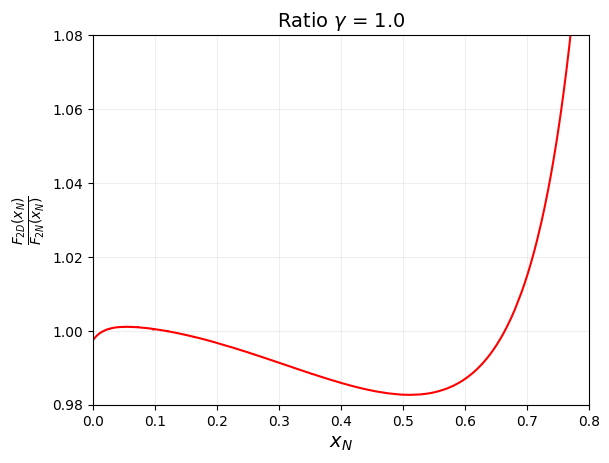

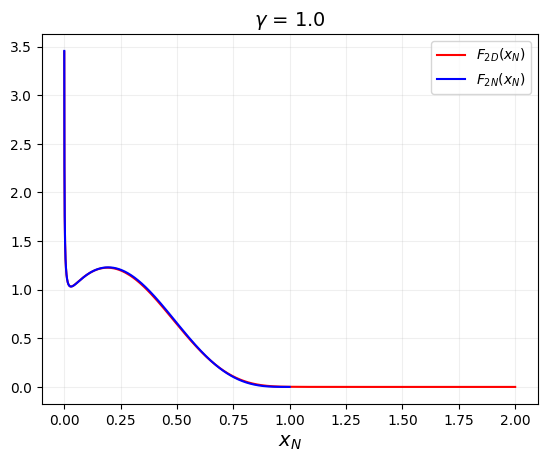

In [9]:
fig3, ax3 = plt.subplots()
x_N = x * 2
ax3.plot(x_N, ratio, 'r')
ax3.grid(alpha = 0.2)
ax3.set_xlabel(r'$x_N$', fontsize = 14)
ax3.set_ylabel(r'$\frac{F_{2D}(x_N)}{F_{2N}(x_N)}$', fontsize = 14)
ax3.set_title(fr'Ratio $\gamma$ = {gamma_fixed}', fontsize = 14)
ax3.set_xlim(0.0, 0.8)
ax3.set_ylim(0.98, 1.08)
# ax3.set_yscale('log')
# fig3.savefig(f'plots/ratio_{time.time():.0f}.pdf')

fig2, ax2 = plt.subplots()
# ax2.plot(x, integral_result_list, 'r', label = r'$\int_{x_D}^1 dy_D f_0(y_D;\gamma)F_{2N}(x_D/y_D)$')
ax2.plot(x_N, integral_result_list, 'r', label = r'$F_{2D}(x_N)$')
ax2.plot(x_N, simple_f2_list, 'b', label = r'$F_{2N}(x_N)$')
ax2.grid(alpha = 0.2)
ax2.set_xlabel(r'$x_N$', fontsize = 14)
ax2.set_title(fr'$\gamma$ = {gamma_fixed}', fontsize = 14)
ax2.legend()
# fig2.savefig(f'plots/integral_{time.time():.0f}.pdf')